# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **ECCO**

In [93]:
from dask.distributed import Client

client = Client("tcp://10.32.16.4:40299")
client

Client Scheduler: tcp://10.32.16.4:40299 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 15 Cores: 30 Memory: 172.50 GB


In [21]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba

In [4]:
xr.set_options(display_style='text')

In [44]:
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/coords_wg.zarr')) #didn't upload wg region
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tns.zarr'))
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg.zarr'))
ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_vel.zarr'))
ds = xr.merge([ds_tns, ds_slt, ds_tmp, ds_vel])
ds

<xarray.Dataset>
Dimensions:                   (i: 95, i_g: 96, j: 50, j_g: 51, k: 50, k_l: 50, time: 288, time_snp: 287)
Coordinates:
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * time_snp                  (time_snp) datetime64[ns] 1992-02-01 ... 2015-12-01
  * k_l                       (k_l) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i, i_g, j, j_g
Data variables:
    SALT                      (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    SALT_snp                  (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA                     (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA_snp                 (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    dt                        (time) float32 dask.array<chunksize=(288,), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    salt_plume                (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_SLT          (k, time, j, i) float32 dask.array<chunksize=(50, 1, 50, 95), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_TH      (k, time, j, i) float32 dask.array<chunksize=(50, 1, 50, 95), meta=np.ndarray>
    sw_flux_conv_TH           (time, j, i, k) float32 dask.array<chunksize=(1, 50, 95, 50), meta=np.ndarray>
    total_tendency_TH_truth   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    UVEL                      (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    VVEL                      (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    WVEL                      (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>

In [6]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

In [7]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))

In [8]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

# <font color='Green'> \begin{equation*} Temperature \end{equation*} </font>

## <font color='Green'> \begin{equation*} \alpha \approx - \frac{1}{\rho} \frac{\partial \rho}{\partial \theta} \end{equation*} </font>

In [25]:
runit2mass = 1.035e3 #rho_0
heat_capacity_cp = 3.994e3 #J/˚K/kg

In [24]:
drhodt = xr.apply_ufunc(jmd95numba.drhodt, ds.SALT, ds.THETA, 2000,
                        output_dtypes=[ds.SALT.dtype],
                        dask='parallelized').reset_coords(drop=True).load()

In [26]:
alpha = - drhodt / runit2mass

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-SLT-truth} + R1 \end{equation*} </font>

In [85]:
# define bins
delta_theta = 0.1
theta_bins = np.arange(-2, 4, delta_theta)
#define theta_bins for WG range
vol = (coords.drF * coords.rA * coords.hFacC)

In [84]:
# theta distribution in WG region
theta_dist = histogram(ds.THETA_snp.rename('theta'), bins=[theta_bins],
                       weights=vol_alpha, dim=['i', 'j', 'k'])

AssertionError: 

In [18]:
# cumulative volume
V = theta_dist.cumsum(dim='theta_bin')

In [17]:
delta_V = V.diff(dim='time_snp')
delta_V.coords['time'] = 'time_snp', ds.time[1:-1].values

## $\frac{\partial \mathcal{V}}{\partial t}$

In [19]:
dVdt = delta_V.swap_dims({'time_snp': 'time'}) / ds.dt[1:-1]
dVdt.load()

<xarray.DataArray (time: 286, theta_bin: 59)>
array([[  2641806.14743295,  -3777985.21358876,  -7118363.39984674, ...,
                0.        ,         0.        ,         0.        ],
       [  5718294.78442055,   4319388.38040621,   6869735.18107527, ...,
                0.        ,         0.        ,         0.        ],
       [  4885779.96859259,  14025875.82380247,  18344917.81432099, ...,
                0.        ,         0.        ,         0.        ],
       ...,
       [ -3397265.30034568,   1272283.38844444,   5188570.66054321, ...,
                0.        ,         0.        ,         0.        ],
       [  4408831.15756272,  12989736.40009558,  23426245.39928316, ...,
                0.        ,         0.        ,         0.        ],
       [ -8380410.57916049, -22680698.02508642, -27939560.65916049, ...,
                0.        ,         0.        ,         0.        ]])
Coordinates:
    time_snp   (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85
  * time       (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

## $\Omega_{total}$

In [45]:
omega_total = -histogram(ds.THETA.rename('theta').chunk({'i':-1}), bins=[theta_bins],
                         weights=(alpha*ds.total_tendency_TH_truth.fillna(0.)),
                         dim=['i', 'j', 'k']) / delta_theta

In [46]:
omega_total.load()

<xarray.DataArray 'histogram_theta' (time: 288, theta_bin: 59)>
array([[   -0.        ,    -0.        ,    -0.        , ...,
           -0.        ,    -0.        ,    -0.        ],
       [  208.73611358,  -109.98684075,  -448.60588214, ...,
           -0.        ,    -0.        ,    -0.        ],
       [  113.67753052,   301.60214146,   284.38693913, ...,
           -0.        ,    -0.        ,    -0.        ],
       ...,
       [   76.19848298,  1021.82326382,  2364.89114531, ...,
           -0.        ,    -0.        ,    -0.        ],
       [ -204.54671417, -1456.22128393, -3147.69934596, ...,
           -0.        ,    -0.        ,    -0.        ],
       [   -0.        ,    -0.        ,    -0.        , ...,
           -0.        ,    -0.        ,    -0.        ]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85

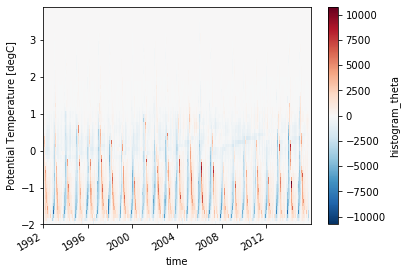

In [47]:
omega_total.plot(x='time')

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

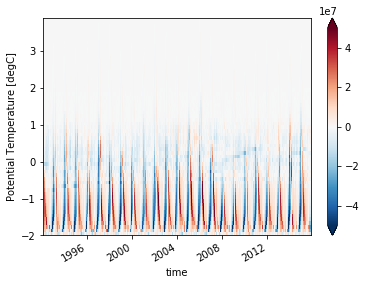

In [50]:
R1 = dVdt - omega_total[1:-1]
R1.plot(x='time', vmax=5e7)

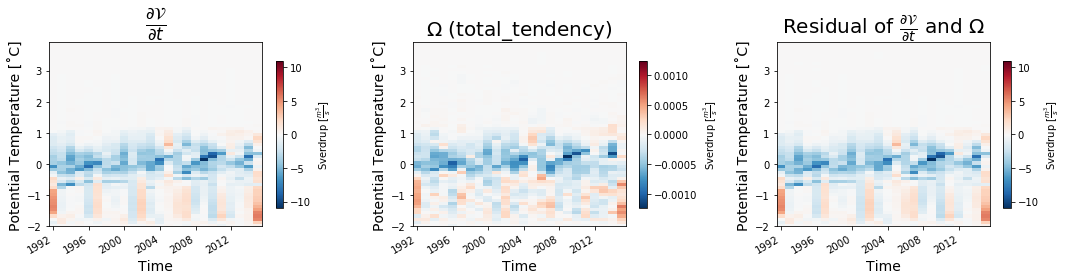

In [51]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$', fontsize=24)

(omega_total[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title('$\Omega$ (total_tendency)', fontsize=20)

(R1/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$', fontsize=20)

plt.tight_layout();

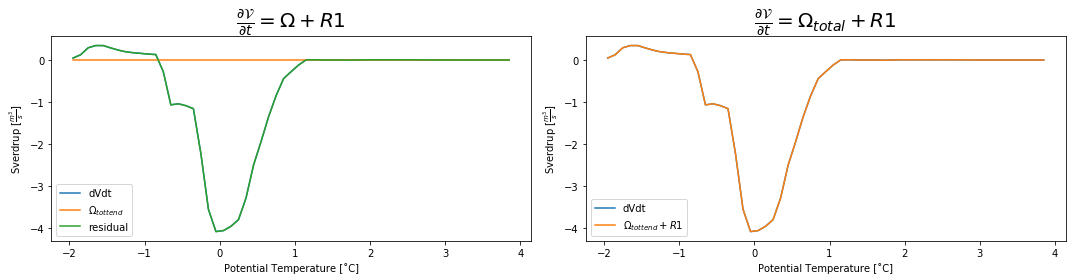

In [52]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel('Potential Temperature [˚C]')
ax0.legend()
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + R1$', fontsize=20)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel('Potential Temperature [˚C]')
ax1.legend()
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$', fontsize=20)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [94]:
ds_tmp = ds_tmp * alpha

In [95]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(ds.THETA.rename('theta').chunk({'i':-1}), bins=[theta_bins],
                     weights=(variable.fillna(0.)), dim=['i', 'j', 'k'])
    return hist / delta_theta

In [96]:
all_tendencies = list(ds_tmp)
all_tendencies

['conv_horiz_adv_flux_TH',
 'conv_horiz_diff_flux_TH',
 'conv_vert_adv_flux_TH',
 'conv_vert_diff_flux_TH',
 'surface_flux_conv_TH',
 'sw_flux_conv_TH',
 'total_tendency_TH_truth']

In [97]:
all_dsets = xr.merge([histogram_func(ds_tmp[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])
all_dsets

<xarray.Dataset>
Dimensions:                        (theta_bin: 59, time: 288)
Coordinates:
  * time                           (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * theta_bin                      (theta_bin) float64 -1.95 -1.85 ... 3.75 3.85
Data variables:
    OMEGA_conv_horiz_adv_flux_TH   (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_TH  (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_TH    (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_TH   (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_surface_flux_conv_TH     (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_sw_flux_conv_TH          (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>
    OMEGA_total_tendency_TH_truth  (time, theta_bin) float64 dask.array<chunksize=(1, 59), meta=np.ndarray>

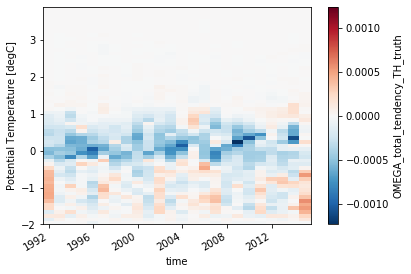

In [98]:
#checking to see if it looks the same as omega_total subplot above (and it does!)
(-all_dsets.OMEGA_total_tendency_TH_truth/1e6).resample(time='AS').mean(dim='time').plot(x='time')

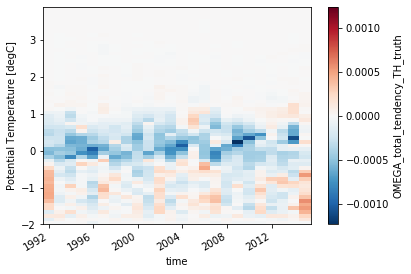

In [98]:
#checking to see if it looks the same as omega_total subplot above (and it does!)
(-all_dsets.OMEGA_total_tendency_TH_truth/1e6).resample(time='AS').mean(dim='time').plot(x='time')

In [101]:
omega_trans_rate = - (all_dsets.OMEGA_conv_horiz_diff_flux_TH + 
                      all_dsets.OMEGA_conv_vert_diff_flux_TH +
                      all_dsets.OMEGA_sw_flux_conv_TH + 
                      all_dsets.OMEGA_surface_flux_conv_TH)
omega_trans_rate.load()

<xarray.DataArray (time: 288, theta_bin: 59)>
array([[  -43.41277403,  -596.42448363, -1311.15308723, ...,
           -0.        ,    -0.        ,    -0.        ],
       [  200.96498857,   -60.77196626,  -364.12208573, ...,
           -0.        ,    -0.        ,    -0.        ],
       [   13.39192103,   297.75516159,   377.1716997 , ...,
           -0.        ,    -0.        ,    -0.        ],
       ...,
       [   68.07987849,   969.9807851 ,  2371.05982437, ...,
           -0.        ,    -0.        ,    -0.        ],
       [ -213.95865575, -1341.92557154, -2855.75028322, ...,
           -0.        ,    -0.        ,    -0.        ],
       [  -70.38137999, -1167.84871897, -2892.59386925, ...,
           -0.        ,    -0.        ,    -0.        ]])
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 3.65 3.75 3.85

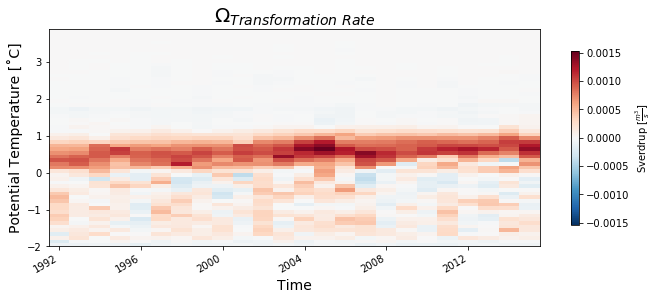

In [102]:
(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', figsize=(11,4), 
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Potential Temperature [˚C]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title(r'$\Omega_{Transformation\ Rate}$', fontsize=20);

## <font color='Green'> \begin{equation*} \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} (Numerical Mixing) </font>

# <font color='Green'> \begin{equation*} Salinity \end{equation*} </font>